# CNN with a Trainable Embedding Layer

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

import numpy as np
import tensorflow as tf

## Build test and training sets & define preprocessing

In [3]:
NUM_WORDS = 50000
MAXLEN = 5000
NGRAM_RANGE = 1

In [4]:
train, test, preproc = text.texts_from_csv('../data/train_80_10_10.csv',
                                          'cleaned_contents',
                                          label_columns=['Discrimination_Label'],
                                          val_filepath='../data/test_80_10_10.csv',
                                          max_features=NUM_WORDS,
                                          maxlen=MAXLEN,
                                          ngram_range=NGRAM_RANGE)

detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 17531
Nrows: 647
647 train sequences
train sequence lengths:
	mean : 1501
	95percentile : 3939
	99percentile : 7668
x_train shape: (647,5000)
y_train shape: (647, 2)
Is Multi-Label? False
81 test sequences
test sequence lengths:
	mean : 1510
	95percentile : 3450
	99percentile : 6646
x_test shape: (81,5000)
y_test shape: (81, 2)


## Build the model

In [5]:
def _build_cnn(maxlen, max_features, embed_dim, filters, kernels,
               dropout=0.1,
               loss_func='categorical_crossentropy',
               activation = 'softmax', metrics=['accuracy'],
               verbose=1, optimizer='adam'):
    
    embedding_matrix = np.ones((max_features, 1))
    embedding_matrix[0] = 0

    # set up the model
    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(max_features, embed_dim, input_length=maxlen, 
                                  trainable=True)(inp)
    x0 = tf.keras.layers.Conv1D(filters=filters,
                               kernel_size=kernels[0],
                               activation='relu')(x)
    x0 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[0] + 1)(x0)

    x1 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[1],
                                activation='relu')(x)
    x1 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[1] + 1)(x1)
    
    x2 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[2],
                                activation='relu')(x)
    x2 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[2] + 1)(x2)
    
    x3 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[3],
                                activation='relu')(x)
    x3 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[3] + 1)(x3)

    x4 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[4],
                                activation='relu')(x)
    x4 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[4] + 1)(x4)

    x = tf.keras.layers.concatenate([x0, x1, x2, x3, x4])

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(2, activation=activation)(x)
    model = tf.keras.Model(inputs=inp, outputs=outputs)
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [6]:
model = _build_cnn(5000, 50000, 100, filters=32, kernels=[2, 3, 4, 5, 6], dropout=0.4)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

In [7]:
learner.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 100)    5000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4999, 32)     6432        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4998, 32)     9632        embedding[0][0]                  
______________________________________________________________________________________________

## Define and train the model

In [8]:
learner.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 100)    5000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4999, 32)     6432        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4998, 32)     9632        embedding[0][0]                  
______________________________________________________________________________________________

### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


Train on 647 samples
Epoch 1/5
647/647 [==============================] - 6s 9ms/sample - loss: 0.7017 - accuracy: 0.4915
Epoch 2/5
647/647 [==============================] - 4s 6ms/sample - loss: 0.6909 - accuracy: 0.5224
Epoch 3/5
647/647 [==============================] - 4s 6ms/sample - loss: 0.6689 - accuracy: 0.5873
Epoch 4/5
647/647 [==============================] - 4s 6ms/sample - loss: 0.9680 - accuracy: 0.5641
Epoch 5/5
128/647 [====>.........................] - ETA: 2s - loss: 42.8169 - accuracy: 0.5859

done.
Visually inspect loss plot and select learning rate associated with falling loss


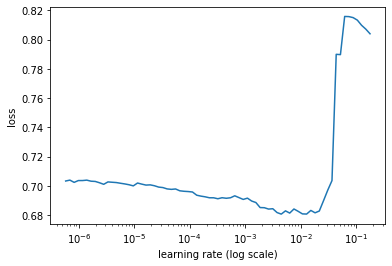

In [9]:
learner.lr_find(show_plot=True)

### Train

In [10]:
learner.autofit(0.001, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 81 samples
Epoch 1/1024
647/647 [==============================] - 5s 8ms/sample - loss: 0.6910 - accuracy: 0.5440 - val_loss: 0.6825 - val_accuracy: 0.5432
Epoch 2/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6460 - accuracy: 0.5935 - val_loss: 0.6624 - val_accuracy: 0.5556
Epoch 3/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6135 - accuracy: 0.7048 - val_loss: 0.6586 - val_accuracy: 0.5432
Epoch 4/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.5812 - accuracy: 0.7079 - val_loss: 0.6238 - val_accuracy: 0.7531
Epoch 5/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.5221 - accuracy: 0.8454 - val_loss: 0.6094 - val_accuracy: 0.6543
Epoch 6/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.4585 - accur

## Examine results

In [11]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.72      0.70      0.71        37
           1       0.76      0.77      0.76        44

    accuracy                           0.74        81
   macro avg       0.74      0.74      0.74        81
weighted avg       0.74      0.74      0.74        81



array([[26, 11],
       [10, 34]])

## Explain a prediction

In [12]:
import pandas as pd
X_test = pd.read_csv('../data/test.csv')['cleaned_contents']

In [13]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [14]:
predictor.explain('As the perpetrator is the sole breadwinner for his family, I reduce his sentence by two years.')